In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize

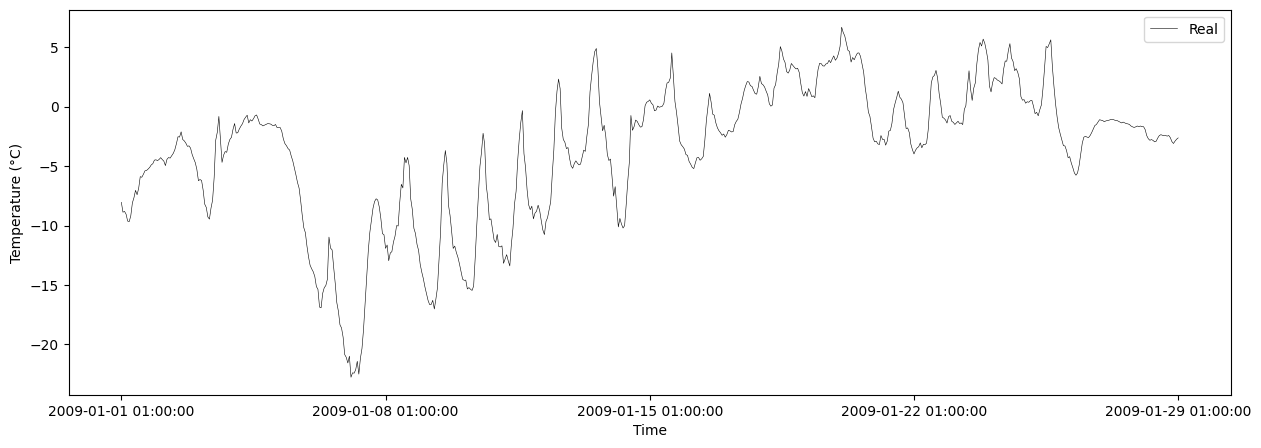

In [2]:
# Cargar datos
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')

# Tomar solo el 50% de los datos
df = df[:int(len(df)//2)]

target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

# Graficar datos reales
plt.figure(figsize=(15, 5))
plt.plot(time[:673], load[:673], color='k', label='Real', linewidth=0.4)
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

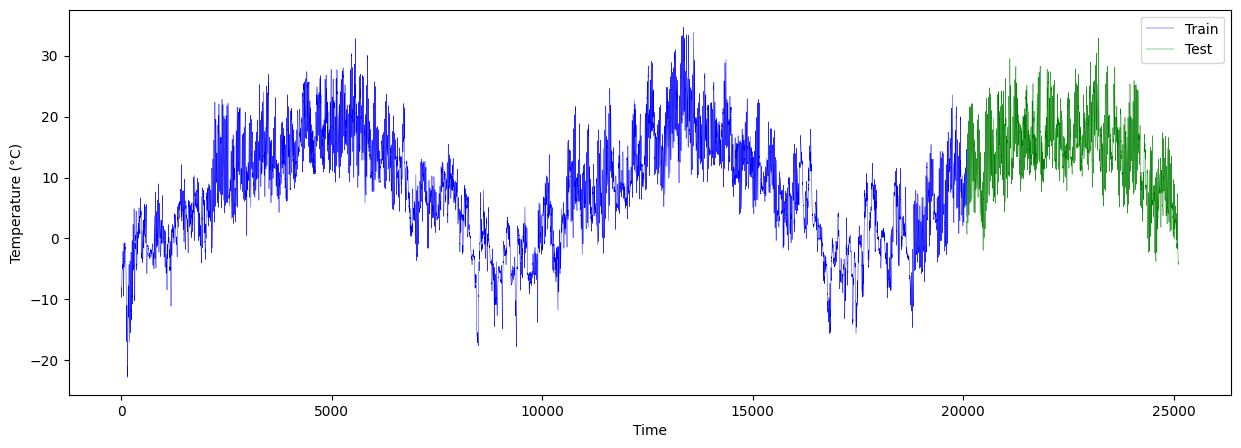

In [3]:
# Dividir los datos en entrenamiento y prueba
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

# Graficar conjunto de entrenamiento y prueba
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train', color='b', linewidth=0.3)
plt.plot(test, label='Test', color='g', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [5]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])

In [6]:
# Descomposición EEMD
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i + 1) for i in range(0, imf_eemd.shape[1])]

In [7]:
# Función para preparar datos
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [8]:
# Parámetros del modelo
c = 10
d = 1
epochs = 8
test_length = len(test)

In [9]:
# Función para entrenar el modelo LSTM
def train_lstm_model(imf_series, train_data, test_length, c, d, epochs):
    imf_lstm_X, imf_lstm_y, scaler = prepare_data(imf_series)
    imf_lstm_X = imf_lstm_X.reshape((imf_lstm_X.shape[0], 1, imf_lstm_X.shape[1]))

    model = Sequential()
    model.add(LSTM(c, activation='relu', input_shape=(imf_lstm_X.shape[1], imf_lstm_X.shape[2])))
    model.add(Dense(d))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(imf_lstm_X, imf_lstm_y, epochs=epochs, verbose=0)
    imf_lstm_fc = model.predict(imf_lstm_X[-test_length:].reshape((test_length, 1, 1)))
    imf_lstm_fc = scaler.inverse_transform(imf_lstm_fc)
    
    return imf_lstm_fc, history

In [10]:
# Entrenar modelos para cada IMF
imf_lstm_fc_list = []
for i in range(1, 11):
    imf_series = imf_eemd_df[f'imf_eemd_{i}']
    imf_lstm_fc, history = train_lstm_model(imf_series, train, test_length, c, d, epochs)
    imf_lstm_fc_list.append(imf_lstm_fc)

# Sumar las predicciones de todos los IMF
imf_lstm_fc = np.sum(imf_lstm_fc_list, axis=0)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


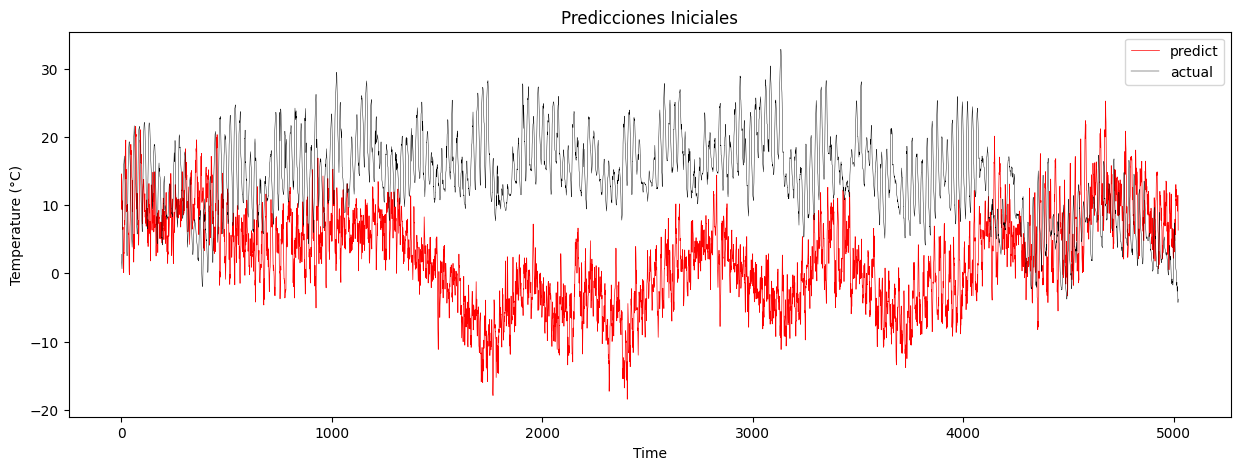

In [11]:
# Graficar predicciones iniciales
plt.figure(figsize=(15, 5))
plt.plot(imf_lstm_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.title('Predicciones Iniciales')
plt.show()

In [12]:
# Calcular métricas
RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc, squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc)
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc)

print('RMSE (Inicial) = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE (Inicial) = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE (Inicial) = {}'.format(MAPE_EEMD_LSTM))

RMSE (Inicial) = 15.840965981862244 
MAE (Inicial) = 13.555565160282004 
MAPE (Inicial) = 3285816718177.0312


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
# Definir función de minimización
def dummy1(c):
    global test
    global imf_lstm_fc
    return mean_squared_error(test, imf_lstm_fc + c)

# Minimización
res1 = minimize(dummy1, 0, method='nelder-mead',
                 options={'xatol': 1e-8, 'disp': True})
print('Valor óptimo de c:', res1.x)

Optimization terminated successfully.
         Current function value: 113.896143
         Iterations: 46
         Function evaluations: 96
Valor óptimo de c: [11.70641116]


In [15]:
# Ajustar las predicciones con el residuo
imf_lstm_fc_adjusted = imf_lstm_fc + res1.x[0]

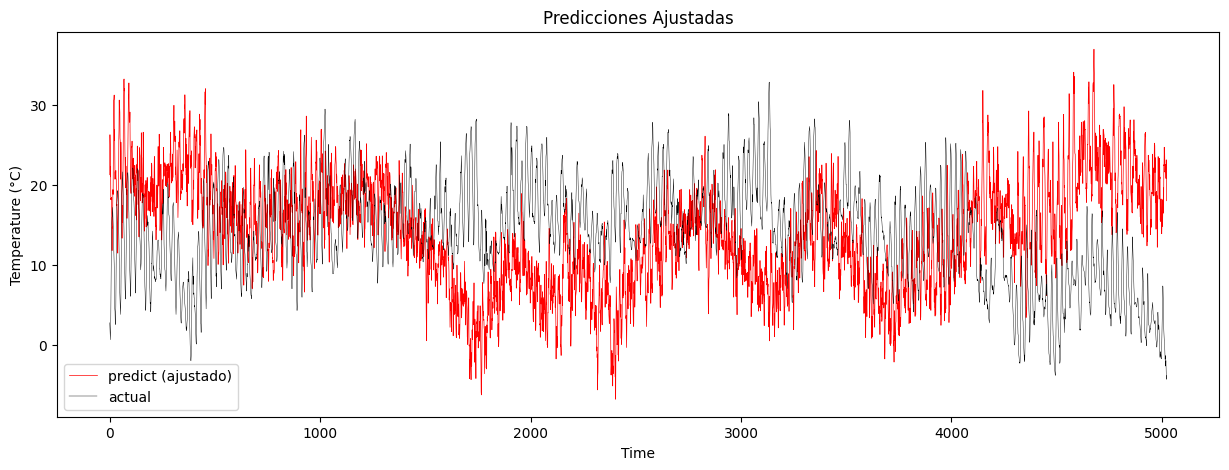

In [16]:
# Graficar predicciones ajustadas
plt.figure(figsize=(15, 5))
plt.plot(imf_lstm_fc_adjusted, label='predict (ajustado)', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.title('Predicciones Ajustadas')
plt.show()

In [17]:
# Calcular métricas ajustadas
RMSE_EEMD_LSTM_adjusted = mean_squared_error(test, imf_lstm_fc_adjusted, squared=False)
MAE_EEMD_LSTM_adjusted = mean_absolute_error(test, imf_lstm_fc_adjusted)
MAPE_EEMD_LSTM_adjusted = mean_absolute_percentage_error(test, imf_lstm_fc_adjusted)

print('RMSE (Ajustado) = {}'.format(RMSE_EEMD_LSTM_adjusted), 
      '\nMAE (Ajustado) = {}'.format(MAE_EEMD_LSTM_adjusted), 
      '\nMAPE (Ajustado) = {}'.format(MAPE_EEMD_LSTM_adjusted))

RMSE (Ajustado) = 10.672213603920358 
MAE (Ajustado) = 8.641093846723043 
MAPE (Ajustado) = 13781733470392.033


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
